# Charting PYLON Baselined Analysis Results

When you perform analysis with PYLON you receive aggregated results from the API. 

We carry out much of work with PYLON in iPython as by its nature the results is a documented workflow that can be easily shared.

In this notebook we'll take a look at how you can use common Python libraries to chart analysis results when you are analyzing against a **baseline audience**.

For each scenario we'll declare a function that we can reuse in future.

## Assumed knowledge

We won't explain all the basics of charting in this notebook. To get started with charting analysis results see [Charting PYLON Analysis Results](Charting PYLON Analysis Results.ipynb).

## Environment

To create this notebook we used:

* Python 2.7.6
* iPython 4.0.0
* pandas
* [DataSift client library](http://dev.datasift.com/tools/client-libraries)

The best way to install the above requirements is using [Anaconda](https://www.continuum.io/downloads). Anaconda provides a tested installation bundle including most popular Python packages.

## Baselining your analysis

It can be very powerful to show your results in comparison to another audience, we call this practice baselining.

When you carry out such analysis you'll record interactions for your audience you are analyzing into one index, then typically record data for your baseline audience into another index using a different filter. You may want to compare your audience to the general Facebook audience, to a different geography or demographic. This depends on your use case.

In this notebook we're assuming you submit the same analysis query to two different indexes and you want to plot both results for comparison.

## Normalizing results for comparison

You may want to compare absolute values from your analysis or 'normalize' the results first so you can focus on the relative differences between the audiences. We'll look at both in our examples.

Let's declare some functions to help with normalization. 

The first function 'normalize_val' simply casts a value to a float and divides it by the total which we supply. We need this as we are using the apply() function for the DataFrames we are normalizing.

The second function 'normalize_results' takes a list of dataframes and the name of column (given by the key argument). The function assumes each dataframe contains a column with the name provided. The total of all values in this column for each dataframe is summed. Then each value in the named column in each dataframe will be divided by this overall total, and added to a new column called 'normalized'. Effectively the normalzied values across the dataframes will add to 1 in the end, so we have normalized the values in the named column across the dataframes provided.

In [1]:
# Simple function to use in our normalization 'apply' step
def normalize_val(total, val):
    return float(val) / total

# Normalizes a collection of dataframes, so all values across the dataframes sum to 1
def normalize_results(dfs, key):

    result = []
    total = 0

    # Sum all values in all dataframes
    for df in dfs:
        total += df[key].sum()
    
    # Normalize all dataframes by dividing by total sum above
    for df in dfs:
        df_copy = pd.DataFrame.copy(df,deep=True)
        df_copy['normalized'] = df.apply(lambda row: normalize_val(total, row[key]), axis=1)
        result.append(df_copy)
        
    return result

To see these functions in action let's look at an example dataframe and then see it normalized.

In [4]:
import json
import pandas as pd

test_data = '''[
            {
                "key": 1448496000,
                "interactions": 312200,
                "unique_authors": 259900
            },
            {
                "key": 1448582400,
                "interactions": 539700,
                "unique_authors": 414100
            },
            {
                "key": 1448668800,
                "interactions": 578600,
                "unique_authors": 475600
            },
            {
                "key": 1448755200,
                "interactions": 561000,
                "unique_authors": 439600
            },
            {
                "key": 1448841600,
                "interactions": 588600,
                "unique_authors": 495500
            },
            {
                "key": 1448928000,
                "interactions": 608100,
                "unique_authors": 496800
            }
        ]'''

df_test = pd.DataFrame.from_records(json.loads(test_data),index='key',exclude=['interactions'])

print normalize_results([df_test],'unique_authors')[0]

            unique_authors  normalized
key                                   
1448496000          259900    0.100678
1448582400          414100    0.160411
1448668800          475600    0.184234
1448755200          439600    0.170289
1448841600          495500    0.191943
1448928000          496800    0.192446


## Plotting time series for comparison

We'll start by looking at time series.

In this example we:
* Parse both of our mocked API results into dictionaries. (Note we take only the **interactions** values from each to make comparison easier)
* **Optionally** normalizing the results before comparison, specified by the **normalize** argument
* Convert both results to dataframe and join these for plotting
* Plot the chart specifying 'silver' as the colour for the baseline result

In [5]:
import json

ts_audience_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "timeSeries",
        "parameters": {
            "interval": "day"
        },
        "results": [
            {
                "key": 1448496000,
                "interactions": 312200,
                "unique_authors": 259900
            },
            {
                "key": 1448582400,
                "interactions": 539700,
                "unique_authors": 414100
            },
            {
                "key": 1448668800,
                "interactions": 578600,
                "unique_authors": 475600
            },
            {
                "key": 1448755200,
                "interactions": 561000,
                "unique_authors": 439600
            },
            {
                "key": 1448841600,
                "interactions": 588600,
                "unique_authors": 495500
            },
            {
                "key": 1448928000,
                "interactions": 608100,
                "unique_authors": 496800
            }
        ],
        "redacted": false
    }
}'''

ts_baseline_result = '''{
    "interactions": 3240400,
    "unique_authors": 1824300,
    "analysis": {
        "analysis_type": "timeSeries",
        "parameters": {
            "interval": "day"
        },
        "results": [
            {
                "key": 1448496000,
                "interactions": 811400,
                "unique_authors": 667900
            },
            {
                "key": 1448582400,
                "interactions": 919300,
                "unique_authors": 602900
            },
            {
                "key": 1448668800,
                "interactions": 726600,
                "unique_authors": 673200
            },
            {
                "key": 1448755200,
                "interactions": 779200,
                "unique_authors": 674300
            },
            {
                "key": 1448841600,
                "interactions": 833600,
                "unique_authors": 740500
            },
            {
                "key": 1448928000,
                "interactions": 648100,
                "unique_authors": 506800
            }
        ],
        "redacted": false
    }
}'''

ts_audience = json.loads(ts_audience_result)
ts_baseline = json.loads(ts_baseline_result)

In [6]:
# This causes charts to be drawn inline
%pylab inline

# Import pandas for data manipulation
import pandas as pd

# Plots a timeseries baselined by number of interactions
def chart_timeseries_baseline_interactions(ts_audience, ts_baseline, normalized=True):

    if not ts_audience['analysis']['redacted'] and not ts_baseline['analysis']['redacted']:

        df_audience = pd.DataFrame.from_records(ts_audience['analysis']['results'],index='key',exclude=['unique_authors'])
        df_baseline = pd.DataFrame.from_records(ts_baseline['analysis']['results'],index='key',exclude=['unique_authors'])
        
        # If normalization is specified normalize each dataframe before plotting
        if normalized:
            df_audience = normalize_results([df_audience], 'interactions')[0]
            df_baseline = normalize_results([df_baseline], 'interactions')[0]
            
            # Drop data we don't want to plot
            df_audience = df_audience.drop('interactions',1)
            df_baseline = df_baseline.drop('interactions',1)

        df_plot = pd.concat([df_audience,df_baseline], axis=1, keys=['audience', 'baseline'])

        df_plot.index=df_plot.index.map(datetime.datetime.fromtimestamp)
        df_plot.sort().plot(figsize=(14,6), color=['red','silver'])

Populating the interactive namespace from numpy and matplotlib


With our function now declared we can plot both a absolute and normalized version of our chart.

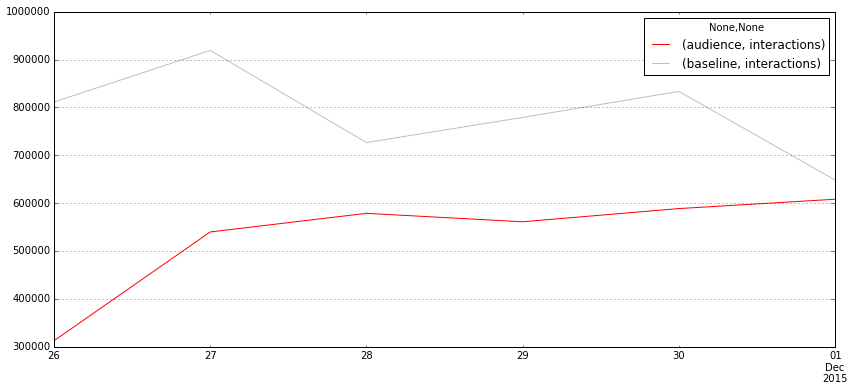

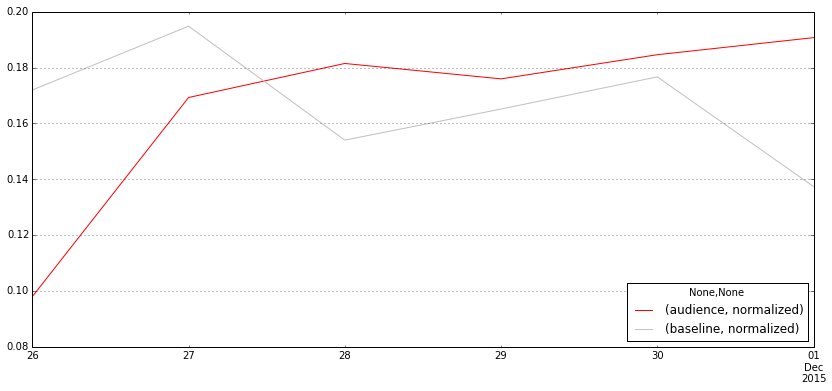

In [7]:
# Absolute
chart_timeseries_baseline_interactions(ts_audience, ts_baseline,normalized=False)

# Normalized
chart_timeseries_baseline_interactions(ts_audience, ts_baseline)

## Plotting frequency distributions for comparison

You can apply the same idea to frequency distributions of course.

In this example we:
* Parse both of our mocked API results into dictionaries.
* Note we take only the **unique_authors** values from each to make comparison easier
* **Optionally** normalize the results for comparison.
* Merge both results into one dataframe. 
* Plot each result in turn on the same axes, layering the visualization. Again 'silver' is used as the colour for the baseline.

In [8]:
fd_audience_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "freqDist",
        "parameters": {
            "target": "fb.author.country",
            "threshold": 6
        },
        "results": [
            {
                "key": "United States",
                "interactions": 1121300,
                "unique_authors": 781400
            },
            {
                "key": "Brazil",
                "interactions": 283100,
                "unique_authors": 204800
            },
            {
                "key": "Turkey",
                "interactions": 181000,
                "unique_authors": 136700
            },
            {
                "key": "United Kingdom",
                "interactions": 172800,
                "unique_authors": 128400
            },
            {
                "key": "Mexico",
                "interactions": 151200,
                "unique_authors": 95000
            },
            {
                "key": "Germany",
                "interactions": 122000,
                "unique_authors": 84800
            }
        ],
        "redacted": false
    }
}'''

fd_baseline_result = '''{
    "interactions": 3188400,
    "unique_authors": 2234300,
    "analysis": {
        "analysis_type": "freqDist",
        "parameters": {
            "target": "fb.author.country",
            "threshold": 6
        },
        "results": [
            {
                "key": "United States",
                "interactions": 3281400,
                "unique_authors": 1881400
            },
            {
                "key": "Brazil",
                "interactions": 374200,
                "unique_authors": 220200
            },
            {
                "key": "Turkey",
                "interactions": 181000,
                "unique_authors": 146700
            },
            {
                "key": "United Kingdom",
                "interactions": 292400,
                "unique_authors": 258400
            },
            {
                "key": "Mexico",
                "interactions": 151200,
                "unique_authors": 86000
            },
            {
                "key": "Germany",
                "interactions": 139000,
                "unique_authors": 94900
            }
        ],
        "redacted": false
    }
}'''

fd_audience = json.loads(fd_audience_result)
fd_baseline = json.loads(fd_baseline_result)

In [9]:
# Plots a baselined freqdist based on unique_author counts
def chart_freqdist_baseline_uniqueauthors(fd_audience, fd_baseline, normalized=True):

    # Check result is not redacted
    if not fd_audience['analysis']['redacted'] and not fd_baseline['analysis']['redacted']:

        # Extract result data to dataframe
        df_audience = pd.DataFrame.from_records(fd_audience['analysis']['results'],index='key',exclude=['interactions'])
        df_baseline = pd.DataFrame.from_records(fd_baseline['analysis']['results'],index='key',exclude=['interactions'])
        
        # If normalization is specified normalize each dataframe before plotting
        if normalized:
            df_audience = normalize_results([df_audience], 'unique_authors')[0]
            df_baseline = normalize_results([df_baseline], 'unique_authors')[0]

        df_plot = pd.concat([df_audience, df_baseline], axis=1, keys=['audience', 'baseline'])
        
        # Choose which column to plot depending on whether the data has been normalized
        key = 'unique_authors'
        if normalized:
            key = 'normalized'

        # Sort the data and plot a chart
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
        df_plot[('baseline',key)].plot(kind='barh',ax=axes,color='silver',width=0.8,linewidth=0)
        df_plot[('audience',key)].plot(kind='barh',ax=axes)

Again we can plot both absolute and normalized results.

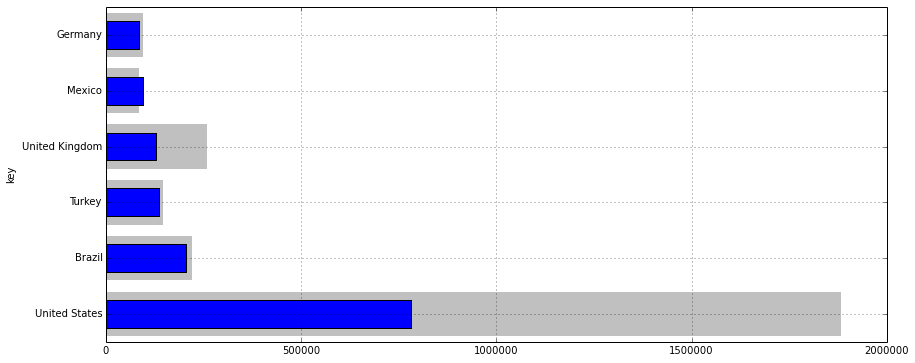

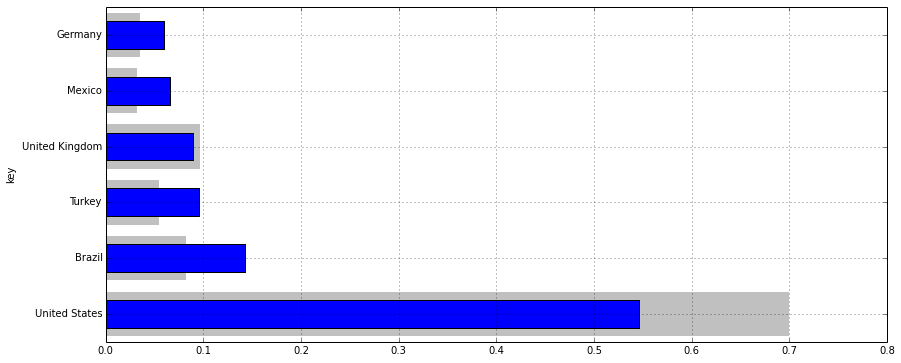

In [10]:
# Absolute
chart_freqdist_baseline_uniqueauthors(fd_audience, fd_baseline, normalized=False)

# Normalized
chart_freqdist_baseline_uniqueauthors(fd_audience, fd_baseline)

## Baselining an age-gender pyramid

If you've previously charted a demographic breakdown as a pyramid, you can also consider a baselined comparison for this.

In this example we:
* Parse both of our mocked API results into dictionaries.
* Create a dataframe for our audience and our baseline audience.
* **Optionally** noramlize the data before plotting.
* For both sexes plot firstly the baseline chart and then on top plot the audience chart.

In this example we also plot a scatter chart that helps to show how far each gender age group over or under-indexes compared to the baseline audience. Here we:
* Create a new dataframe for the indexing values.
* Calculate for each gender / age group the relative value for our audience compared to the baseline audience.
* Plot a scatter chart overlaying male and female results for easy comparison.

In [11]:
nested_audience_result = '''{
    "unique_authors": 556400, 
    "analysis": {
        "analysis_type": "freqDist", 
        "redacted": false, 
        "results": [
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 124500, 
                            "key": "18-24", 
                            "interactions": 151900
                        }, 
                        {
                            "unique_authors": 124200, 
                            "key": "25-34", 
                            "interactions": 146200
                        }, 
                        {
                            "unique_authors": 76400, 
                            "key": "35-44", 
                            "interactions": 96000
                        }, 
                        {
                            "unique_authors": 43800, 
                            "key": "45-54", 
                            "interactions": 57400
                        }, 
                        {
                            "unique_authors": 19500, 
                            "key": "55-64", 
                            "interactions": 26400
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 404800, 
                "key": "male", 
                "interactions": 492000
            }, 
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 34300, 
                            "key": "25-34", 
                            "interactions": 43200
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "35-44", 
                            "interactions": 35600
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "18-24", 
                            "interactions": 34800
                        }, 
                        {
                            "unique_authors": 21400, 
                            "key": "45-54", 
                            "interactions": 26400
                        }, 
                        {
                            "unique_authors": 12600, 
                            "key": "55-64", 
                            "interactions": 15500
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 141400, 
                "key": "female", 
                "interactions": 164500
            }
        ], 
        "parameters": {
            "threshold": 2, 
            "target": "fb.author.gender"
        }
    }, 
    "interactions": 671300
}'''

nested_baseline_result = '''{
    "unique_authors": 556400, 
    "analysis": {
        "analysis_type": "freqDist", 
        "redacted": false, 
        "results": [
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 122500, 
                            "key": "18-24", 
                            "interactions": 151000
                        }, 
                        {
                            "unique_authors": 114200, 
                            "key": "25-34", 
                            "interactions": 136200
                        }, 
                        {
                            "unique_authors": 82400, 
                            "key": "35-44", 
                            "interactions": 104000
                        }, 
                        {
                            "unique_authors": 63800, 
                            "key": "45-54", 
                            "interactions": 77400
                        }, 
                        {
                            "unique_authors": 19300, 
                            "key": "55-64", 
                            "interactions": 26200
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 404800, 
                "key": "male", 
                "interactions": 492000
            }, 
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 49300, 
                            "key": "25-34", 
                            "interactions": 56200
                        }, 
                        {
                            "unique_authors": 39200, 
                            "key": "35-44", 
                            "interactions": 40600
                        }, 
                        {
                            "unique_authors": 33200, 
                            "key": "18-24", 
                            "interactions": 35800
                        }, 
                        {
                            "unique_authors": 19400, 
                            "key": "45-54", 
                            "interactions": 24400
                        }, 
                        {
                            "unique_authors": 11600, 
                            "key": "55-64", 
                            "interactions": 14500
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 141400, 
                "key": "female", 
                "interactions": 164500
            }
        ], 
        "parameters": {
            "threshold": 2, 
            "target": "fb.author.gender"
        }
    }, 
    "interactions": 671300
}'''

nested_audience = json.loads(nested_audience_result)
nested_baseline = json.loads(nested_baseline_result)

In [12]:
from matplotlib import gridspec

# Plots a baselined age-gender pyramid
def  chart_agegender_baselined(nested_audience, nested_baseline, normalized=True):
    if not nested_audience['analysis']['redacted'] and not nested_baseline['analysis']['redacted']:

        # Prepare dataframe for audience
        df_audience_male = pd.DataFrame.from_records(
            nested_audience['analysis']['results'][0]['child']['results'],index='key',exclude=['interactions'])

        df_audience_female = pd.DataFrame.from_records(
            nested_audience['analysis']['results'][1]['child']['results'],index='key',exclude=['interactions'])

        if normalized:
            normal = normalize_results([df_audience_male,df_audience_female], 'unique_authors')
            df_audience_male = normal[0]
            df_audience_female = normal[1]

        df_audience = pd.concat([df_audience_male, df_audience_female], axis=1, keys=['male','female'])

        # Prepare dataframe for baseline
        df_baseline_male = pd.DataFrame.from_records(
            nested_baseline['analysis']['results'][0]['child']['results'],index='key',exclude=['interactions'])

        df_baseline_female = pd.DataFrame.from_records(
            nested_baseline['analysis']['results'][1]['child']['results'],index='key',exclude=['interactions'])

        if normalized:
            normal = normalize_results([df_baseline_male,df_baseline_female], 'unique_authors')
            df_baseline_male = normal[0]
            df_baseline_female = normal[1]

        df_baseline = pd.concat([df_baseline_male, df_baseline_female], axis=1, keys=['male','female'])

        # Create plot layout
        fig = plt.figure(figsize=(15,6))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1])
        axes=map(plt.subplot,gs)

        key = 'unique_authors'

        if normalized:
            key = 'normalized'

        # Find max X value across data sets
        max_xlim=max(df_audience[('male', key)].max(),
            df_audience[('female', key)].max(),
            df_baseline[('male', key)].max(),
            df_baseline[('female', key)].max())

        # Plot pyramid
        female_subplot=df_baseline[('female',key)].plot(kind='barh',ax=axes[0],color='silver',width=0.8,linewidth=0)
        df_audience[('female',key)].plot(kind='barh',ax=axes[0],color='pink',alpha=0.8) #royalblue
        female_subplot.set_xlim([max_xlim,0])

        male_subplot=df_baseline[('male',key)].plot(kind='barh',ax=axes[1],color='silver',width=0.8,linewidth=0)
        df_audience[('male',key)].plot(kind='barh',ax=axes[1],color='mediumblue',alpha=0.8)
        male_subplot.set_xlim([0,max_xlim])

        # Plot scatter chart of indexes
        df_indexes = pd.DataFrame(index=df_audience.index, columns=['male','female'])

        for index,row in df_indexes.iterrows():
            row['male'] = float(df_audience['male'][key][index]) / df_baseline['male'][key][index]
            row['female'] = float(df_audience['female'][key][index]) / df_baseline['female'][key][index]

        df_indexes = df_indexes.reset_index()
        df_indexes['agerank'] = df_indexes.index

        df_indexes.plot(kind='scatter',alpha=0.7,marker='o',x='female',
                  y='agerank',s=300,c='pink',ax=axes[2],ylim=(-0.5,len(df_indexes)-0.5));

        df_indexes.plot(kind='scatter',alpha=0.7,marker='o',x='male',
                  y='agerank',s=300,c='mediumblue',ax=axes[2]);

        # Tidy axis labels
        axes[0].set_xlabel('female authors')
        axes[1].set_xlabel('male authors')
        axes[1].set_ylabel('')
        axes[1].set_yticklabels(['' for item in axes[1].get_yticklabels()])
        for i in (0,1):
            for j in axes[i].xaxis.get_major_ticks():
                j.label.set_rotation(30)

        axes[2].set_ylabel('')
        axes[2].set_xlabel('index')
        axes[2].set_yticklabels(['' for item in axes[2].get_yticklabels()])
        gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

Once again with this function declared we can plot an absolute and normalized version of the chart.

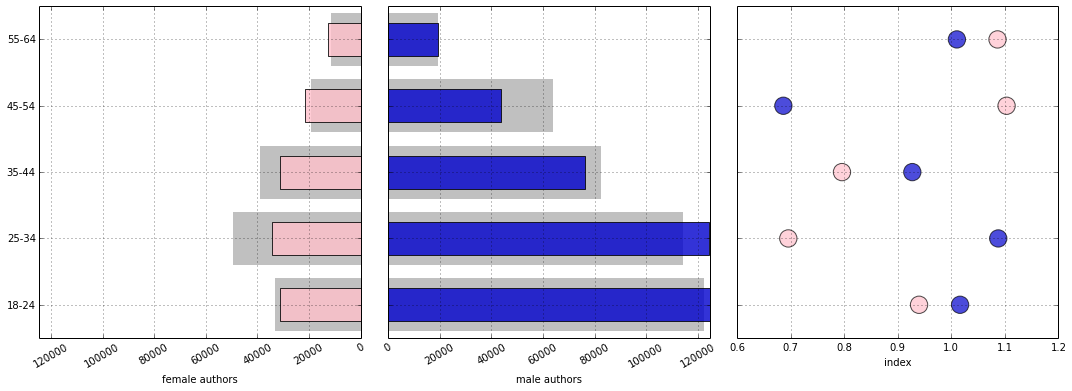

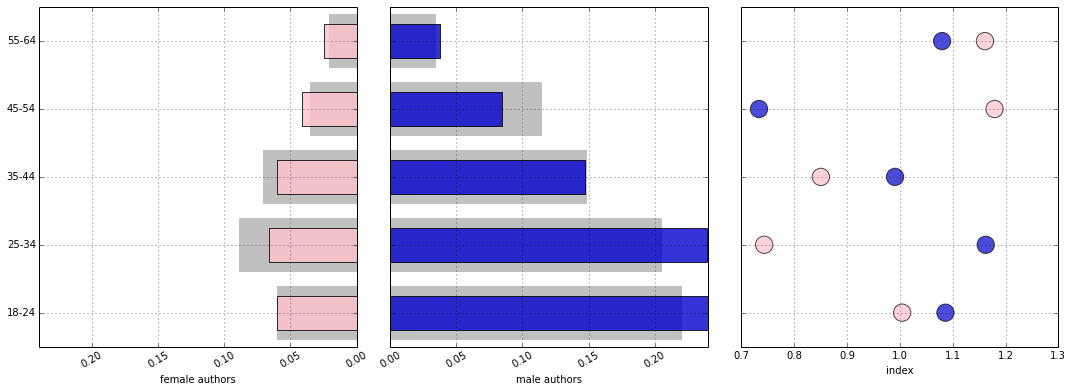

In [13]:
# Absolute
chart_agegender_baselined(nested_audience, nested_baseline, normalized=False)

# Normalized
chart_agegender_baselined(nested_audience, nested_baseline)

## Baselining aggregated time series results

If you've previously charted an aggregated time series chart, you can also consider a baselined comparison for this.

Here we continue the example in the 'Charting PYLON Analysis Results' notebook where a time series result is grouped by each hour of the day across many days. This shows whihch hour of the day on average sees the most activity across the time period.

In this example we:
* Parse both of our mocked API results into dictionaries.
* Create a dataframe for our audience and our baseline audience.
* For each result aggregate the interaction counts by each hour of the day, giving a total count for each hour.
* **Optionally** noramlize the data before plotting.
* Plot both results on a chart for comparison.

In [15]:
audience_multi_days_api_result = '''
{"unique_authors": 59100, "analysis": {"analysis_type": "timeSeries", "redacted": false, "results": [{"unique_authors": 200, "key": 1448841600, "interactions": 200}, {"unique_authors": 300, "key": 1448845200, "interactions": 400}, {"unique_authors": 300, "key": 1448848800, "interactions": 400}, {"unique_authors": 400, "key": 1448852400, "interactions": 400}, {"unique_authors": 300, "key": 1448856000, "interactions": 400}, {"unique_authors": 200, "key": 1448859600, "interactions": 300}, {"unique_authors": 200, "key": 1448863200, "interactions": 200}, {"unique_authors": 100, "key": 1448866800, "interactions": 100}, {"unique_authors": 100, "key": 1448895600, "interactions": 100}, {"unique_authors": 200, "key": 1448899200, "interactions": 200}, {"unique_authors": 200, "key": 1448902800, "interactions": 200}, {"unique_authors": 200, "key": 1448906400, "interactions": 200}, {"unique_authors": 200, "key": 1448910000, "interactions": 300}, {"unique_authors": 200, "key": 1448913600, "interactions": 300}, {"unique_authors": 100, "key": 1448917200, "interactions": 200}, {"unique_authors": 200, "key": 1448920800, "interactions": 200}, {"unique_authors": 100, "key": 1448924400, "interactions": 100}, {"unique_authors": 200, "key": 1448928000, "interactions": 200}, {"unique_authors": 200, "key": 1448931600, "interactions": 200}, {"unique_authors": 200, "key": 1448935200, "interactions": 300}, {"unique_authors": 300, "key": 1448938800, "interactions": 300}, {"unique_authors": 300, "key": 1448942400, "interactions": 300}, {"unique_authors": 200, "key": 1448946000, "interactions": 200}, {"unique_authors": 200, "key": 1448949600, "interactions": 200}, {"unique_authors": 100, "key": 1448953200, "interactions": 100}, {"unique_authors": 100, "key": 1448982000, "interactions": 100}, {"unique_authors": 100, "key": 1448985600, "interactions": 200}, {"unique_authors": 100, "key": 1448989200, "interactions": 100}, {"unique_authors": 100, "key": 1448992800, "interactions": 200}, {"unique_authors": 100, "key": 1448996400, "interactions": 200}, {"unique_authors": 100, "key": 1449000000, "interactions": 100}, {"unique_authors": 100, "key": 1449003600, "interactions": 100}, {"unique_authors": 100, "key": 1449007200, "interactions": 200}, {"unique_authors": 100, "key": 1449010800, "interactions": 200}, {"unique_authors": 200, "key": 1449014400, "interactions": 200}, {"unique_authors": 200, "key": 1449018000, "interactions": 200}, {"unique_authors": 200, "key": 1449021600, "interactions": 200}, {"unique_authors": 200, "key": 1449025200, "interactions": 200}, {"unique_authors": 200, "key": 1449028800, "interactions": 200}, {"unique_authors": 200, "key": 1449032400, "interactions": 200}, {"unique_authors": 200, "key": 1449036000, "interactions": 200}, {"unique_authors": 100, "key": 1449064800, "interactions": 100}, {"unique_authors": 100, "key": 1449068400, "interactions": 100}, {"unique_authors": 100, "key": 1449072000, "interactions": 200}, {"unique_authors": 100, "key": 1449075600, "interactions": 200}, {"unique_authors": 100, "key": 1449079200, "interactions": 200}, {"unique_authors": 200, "key": 1449082800, "interactions": 200}, {"unique_authors": 100, "key": 1449086400, "interactions": 100}, {"unique_authors": 100, "key": 1449090000, "interactions": 100}, {"unique_authors": 200, "key": 1449093600, "interactions": 200}, {"unique_authors": 300, "key": 1449097200, "interactions": 300}, {"unique_authors": 200, "key": 1449100800, "interactions": 200}, {"unique_authors": 200, "key": 1449104400, "interactions": 300}, {"unique_authors": 300, "key": 1449108000, "interactions": 400}, {"unique_authors": 300, "key": 1449111600, "interactions": 300}, {"unique_authors": 100, "key": 1449154800, "interactions": 100}, {"unique_authors": 100, "key": 1449158400, "interactions": 100}, {"unique_authors": 200, "key": 1449162000, "interactions": 200}, {"unique_authors": 200, "key": 1449165600, "interactions": 300}, {"unique_authors": 200, "key": 1449169200, "interactions": 200}, {"unique_authors": 200, "key": 1449172800, "interactions": 200}, {"unique_authors": 100, "key": 1449176400, "interactions": 200}, {"unique_authors": 200, "key": 1449180000, "interactions": 200}, {"unique_authors": 200, "key": 1449183600, "interactions": 300}, {"unique_authors": 200, "key": 1449187200, "interactions": 200}, {"unique_authors": 300, "key": 1449190800, "interactions": 400}, {"unique_authors": 300, "key": 1449194400, "interactions": 300}, {"unique_authors": 300, "key": 1449198000, "interactions": 300}, {"unique_authors": 300, "key": 1449201600, "interactions": 400}, {"unique_authors": 300, "key": 1449205200, "interactions": 300}, {"unique_authors": 100, "key": 1449216000, "interactions": 100}, {"unique_authors": 100, "key": 1449237600, "interactions": 100}, {"unique_authors": 100, "key": 1449241200, "interactions": 200}, {"unique_authors": 200, "key": 1449244800, "interactions": 200}, {"unique_authors": 200, "key": 1449248400, "interactions": 300}, {"unique_authors": 200, "key": 1449252000, "interactions": 200}, {"unique_authors": 200, "key": 1449255600, "interactions": 200}, {"unique_authors": 200, "key": 1449259200, "interactions": 200}, {"unique_authors": 200, "key": 1449262800, "interactions": 200}, {"unique_authors": 200, "key": 1449266400, "interactions": 300}, {"unique_authors": 300, "key": 1449270000, "interactions": 300}, {"unique_authors": 300, "key": 1449273600, "interactions": 400}, {"unique_authors": 600, "key": 1449277200, "interactions": 600}, {"unique_authors": 500, "key": 1449280800, "interactions": 600}, {"unique_authors": 400, "key": 1449284400, "interactions": 500}, {"unique_authors": 400, "key": 1449288000, "interactions": 400}, {"unique_authors": 400, "key": 1449291600, "interactions": 400}, {"unique_authors": 200, "key": 1449295200, "interactions": 200}, {"unique_authors": 100, "key": 1449298800, "interactions": 100}, {"unique_authors": 300, "key": 1449302400, "interactions": 300}, {"unique_authors": 100, "key": 1449306000, "interactions": 100}, {"unique_authors": 100, "key": 1449324000, "interactions": 200}, {"unique_authors": 300, "key": 1449327600, "interactions": 300}, {"unique_authors": 400, "key": 1449331200, "interactions": 400}, {"unique_authors": 400, "key": 1449334800, "interactions": 500}, {"unique_authors": 400, "key": 1449338400, "interactions": 500}, {"unique_authors": 400, "key": 1449342000, "interactions": 400}, {"unique_authors": 300, "key": 1449345600, "interactions": 400}, {"unique_authors": 400, "key": 1449349200, "interactions": 400}, {"unique_authors": 400, "key": 1449352800, "interactions": 400}, {"unique_authors": 500, "key": 1449356400, "interactions": 500}, {"unique_authors": 500, "key": 1449360000, "interactions": 500}, {"unique_authors": 500, "key": 1449363600, "interactions": 500}, {"unique_authors": 500, "key": 1449367200, "interactions": 500}, {"unique_authors": 400, "key": 1449370800, "interactions": 500}, {"unique_authors": 500, "key": 1449374400, "interactions": 500}, {"unique_authors": 300, "key": 1449378000, "interactions": 300}, {"unique_authors": 100, "key": 1449381600, "interactions": 100}, {"unique_authors": 200, "key": 1449385200, "interactions": 200}, {"unique_authors": 100, "key": 1449388800, "interactions": 100}, {"unique_authors": 100, "key": 1449392400, "interactions": 100}, {"unique_authors": 100, "key": 1449414000, "interactions": 100}, {"unique_authors": 100, "key": 1449417600, "interactions": 200}, {"unique_authors": 200, "key": 1449421200, "interactions": 300}, {"unique_authors": 200, "key": 1449424800, "interactions": 300}, {"unique_authors": 200, "key": 1449428400, "interactions": 200}, {"unique_authors": 200, "key": 1449432000, "interactions": 200}, {"unique_authors": 200, "key": 1449435600, "interactions": 300}, {"unique_authors": 400, "key": 1449439200, "interactions": 400}, {"unique_authors": 300, "key": 1449442800, "interactions": 300}, {"unique_authors": 200, "key": 1449446400, "interactions": 300}, {"unique_authors": 200, "key": 1449450000, "interactions": 300}, {"unique_authors": 200, "key": 1449453600, "interactions": 300}, {"unique_authors": 200, "key": 1449457200, "interactions": 200}, {"unique_authors": 200, "key": 1449460800, "interactions": 200}, {"unique_authors": 200, "key": 1449464400, "interactions": 200}, {"unique_authors": 200, "key": 1449468000, "interactions": 200}, {"unique_authors": 100, "key": 1449471600, "interactions": 100}, {"unique_authors": 100, "key": 1449496800, "interactions": 100}, {"unique_authors": 100, "key": 1449500400, "interactions": 100}, {"unique_authors": 200, "key": 1449504000, "interactions": 200}, {"unique_authors": 200, "key": 1449507600, "interactions": 200}, {"unique_authors": 200, "key": 1449511200, "interactions": 200}, {"unique_authors": 300, "key": 1449514800, "interactions": 300}, {"unique_authors": 200, "key": 1449518400, "interactions": 300}, {"unique_authors": 200, "key": 1449522000, "interactions": 200}, {"unique_authors": 200, "key": 1449525600, "interactions": 200}, {"unique_authors": 300, "key": 1449529200, "interactions": 300}, {"unique_authors": 200, "key": 1449532800, "interactions": 300}, {"unique_authors": 300, "key": 1449536400, "interactions": 300}, {"unique_authors": 400, "key": 1449540000, "interactions": 500}, {"unique_authors": 300, "key": 1449543600, "interactions": 400}, {"unique_authors": 100, "key": 1449547200, "interactions": 200}, {"unique_authors": 100, "key": 1449561600, "interactions": 100}, {"unique_authors": 100, "key": 1449583200, "interactions": 100}, {"unique_authors": 100, "key": 1449586800, "interactions": 200}, {"unique_authors": 300, "key": 1449590400, "interactions": 300}, {"unique_authors": 300, "key": 1449594000, "interactions": 300}, {"unique_authors": 200, "key": 1449597600, "interactions": 300}, {"unique_authors": 200, "key": 1449601200, "interactions": 200}, {"unique_authors": 200, "key": 1449604800, "interactions": 200}, {"unique_authors": 200, "key": 1449608400, "interactions": 200}, {"unique_authors": 200, "key": 1449612000, "interactions": 300}, {"unique_authors": 200, "key": 1449615600, "interactions": 300}, {"unique_authors": 200, "key": 1449619200, "interactions": 300}, {"unique_authors": 400, "key": 1449622800, "interactions": 500}, {"unique_authors": 500, "key": 1449626400, "interactions": 500}, {"unique_authors": 300, "key": 1449630000, "interactions": 300}, {"unique_authors": 100, "key": 1449673200, "interactions": 100}, {"unique_authors": 100, "key": 1449676800, "interactions": 100}, {"unique_authors": 100, "key": 1449680400, "interactions": 200}, {"unique_authors": 200, "key": 1449684000, "interactions": 200}, {"unique_authors": 200, "key": 1449687600, "interactions": 200}, {"unique_authors": 200, "key": 1449691200, "interactions": 200}, {"unique_authors": 200, "key": 1449694800, "interactions": 200}, {"unique_authors": 100, "key": 1449698400, "interactions": 200}, {"unique_authors": 100, "key": 1449702000, "interactions": 200}, {"unique_authors": 200, "key": 1449705600, "interactions": 200}, {"unique_authors": 300, "key": 1449709200, "interactions": 300}, {"unique_authors": 200, "key": 1449712800, "interactions": 300}, {"unique_authors": 200, "key": 1449716400, "interactions": 200}, {"unique_authors": 100, "key": 1449759600, "interactions": 100}, {"unique_authors": 100, "key": 1449763200, "interactions": 100}, {"unique_authors": 100, "key": 1449766800, "interactions": 200}, {"unique_authors": 200, "key": 1449770400, "interactions": 300}, {"unique_authors": 100, "key": 1449774000, "interactions": 200}, {"unique_authors": 200, "key": 1449777600, "interactions": 200}, {"unique_authors": 200, "key": 1449781200, "interactions": 200}, {"unique_authors": 200, "key": 1449784800, "interactions": 200}, {"unique_authors": 200, "key": 1449788400, "interactions": 200}, {"unique_authors": 200, "key": 1449792000, "interactions": 200}, {"unique_authors": 200, "key": 1449795600, "interactions": 200}, {"unique_authors": 100, "key": 1449799200, "interactions": 100}, {"unique_authors": 100, "key": 1449849600, "interactions": 100}, {"unique_authors": 100, "key": 1449853200, "interactions": 100}, {"unique_authors": 100, "key": 1449856800, "interactions": 100}, {"unique_authors": 100, "key": 1449860400, "interactions": 200}, {"unique_authors": 100, "key": 1449864000, "interactions": 200}, {"unique_authors": 100, "key": 1449867600, "interactions": 200}, {"unique_authors": 100, "key": 1449871200, "interactions": 100}, {"unique_authors": 200, "key": 1449874800, "interactions": 200}, {"unique_authors": 100, "key": 1449878400, "interactions": 200}, {"unique_authors": 200, "key": 1449882000, "interactions": 300}, {"unique_authors": 200, "key": 1449885600, "interactions": 200}, {"unique_authors": 200, "key": 1449889200, "interactions": 200}, {"unique_authors": 200, "key": 1449892800, "interactions": 200}, {"unique_authors": 200, "key": 1449896400, "interactions": 200}, {"unique_authors": 200, "key": 1449900000, "interactions": 200}, {"unique_authors": 100, "key": 1449903600, "interactions": 100}, {"unique_authors": 100, "key": 1449932400, "interactions": 100}, {"unique_authors": 100, "key": 1449936000, "interactions": 100}, {"unique_authors": 100, "key": 1449939600, "interactions": 100}, {"unique_authors": 200, "key": 1449943200, "interactions": 200}, {"unique_authors": 100, "key": 1449946800, "interactions": 200}, {"unique_authors": 200, "key": 1449950400, "interactions": 200}, {"unique_authors": 200, "key": 1449954000, "interactions": 200}, {"unique_authors": 200, "key": 1449957600, "interactions": 200}, {"unique_authors": 200, "key": 1449961200, "interactions": 200}, {"unique_authors": 300, "key": 1449964800, "interactions": 400}, {"unique_authors": 300, "key": 1449968400, "interactions": 300}, {"unique_authors": 200, "key": 1449972000, "interactions": 300}, {"unique_authors": 300, "key": 1449975600, "interactions": 300}, {"unique_authors": 200, "key": 1449979200, "interactions": 200}, {"unique_authors": 200, "key": 1449982800, "interactions": 200}, {"unique_authors": 100, "key": 1449986400, "interactions": 200}, {"unique_authors": 100, "key": 1449993600, "interactions": 100}, {"unique_authors": 100, "key": 1450018800, "interactions": 100}, {"unique_authors": 100, "key": 1450022400, "interactions": 100}, {"unique_authors": 200, "key": 1450026000, "interactions": 200}, {"unique_authors": 100, "key": 1450029600, "interactions": 200}, {"unique_authors": 100, "key": 1450033200, "interactions": 200}, {"unique_authors": 100, "key": 1450036800, "interactions": 100}, {"unique_authors": 100, "key": 1450040400, "interactions": 100}, {"unique_authors": 200, "key": 1450044000, "interactions": 300}, {"unique_authors": 200, "key": 1450047600, "interactions": 200}], "parameters": {"interval": "hour", "span": 1}}, "interactions": 69400}
'''

baseline_multi_days_api_result = '''
{"unique_authors": 272600, "analysis": {"analysis_type": "timeSeries", "redacted": false, "results": [{"unique_authors": 600, "key": 1448870400, "interactions": 600}, {"unique_authors": 300, "key": 1448874000, "interactions": 300}, {"unique_authors": 200, "key": 1448877600, "interactions": 200}, {"unique_authors": 200, "key": 1448881200, "interactions": 200}, {"unique_authors": 300, "key": 1448884800, "interactions": 300}, {"unique_authors": 400, "key": 1448888400, "interactions": 500}, {"unique_authors": 800, "key": 1448892000, "interactions": 900}, {"unique_authors": 1400, "key": 1448895600, "interactions": 1400}, {"unique_authors": 1700, "key": 1448899200, "interactions": 1700}, {"unique_authors": 1600, "key": 1448902800, "interactions": 1700}, {"unique_authors": 1500, "key": 1448906400, "interactions": 1700}, {"unique_authors": 1600, "key": 1448910000, "interactions": 1600}, {"unique_authors": 1500, "key": 1448913600, "interactions": 1600}, {"unique_authors": 1600, "key": 1448917200, "interactions": 1700}, {"unique_authors": 1900, "key": 1448920800, "interactions": 1900}, {"unique_authors": 1800, "key": 1448924400, "interactions": 1900}, {"unique_authors": 500, "key": 1448928000, "interactions": 600}, {"unique_authors": 700, "key": 1448956800, "interactions": 700}, {"unique_authors": 400, "key": 1448960400, "interactions": 400}, {"unique_authors": 300, "key": 1448964000, "interactions": 300}, {"unique_authors": 200, "key": 1448967600, "interactions": 200}, {"unique_authors": 300, "key": 1448971200, "interactions": 300}, {"unique_authors": 500, "key": 1448974800, "interactions": 500}, {"unique_authors": 900, "key": 1448978400, "interactions": 900}, {"unique_authors": 1400, "key": 1448982000, "interactions": 1400}, {"unique_authors": 1700, "key": 1448985600, "interactions": 1700}, {"unique_authors": 1700, "key": 1448989200, "interactions": 1700}, {"unique_authors": 1600, "key": 1448992800, "interactions": 1700}, {"unique_authors": 1600, "key": 1448996400, "interactions": 1600}, {"unique_authors": 1500, "key": 1449000000, "interactions": 1600}, {"unique_authors": 1500, "key": 1449003600, "interactions": 1600}, {"unique_authors": 1600, "key": 1449007200, "interactions": 1600}, {"unique_authors": 1600, "key": 1449010800, "interactions": 1600}, {"unique_authors": 1200, "key": 1449014400, "interactions": 1200}, {"unique_authors": 700, "key": 1449043200, "interactions": 700}, {"unique_authors": 400, "key": 1449046800, "interactions": 400}, {"unique_authors": 200, "key": 1449050400, "interactions": 200}, {"unique_authors": 200, "key": 1449054000, "interactions": 200}, {"unique_authors": 200, "key": 1449057600, "interactions": 200}, {"unique_authors": 500, "key": 1449061200, "interactions": 500}, {"unique_authors": 1000, "key": 1449064800, "interactions": 1100}, {"unique_authors": 1400, "key": 1449068400, "interactions": 1400}, {"unique_authors": 1700, "key": 1449072000, "interactions": 1700}, {"unique_authors": 1800, "key": 1449075600, "interactions": 1900}, {"unique_authors": 1600, "key": 1449079200, "interactions": 1700}, {"unique_authors": 1700, "key": 1449082800, "interactions": 1700}, {"unique_authors": 1800, "key": 1449086400, "interactions": 1900}, {"unique_authors": 1600, "key": 1449090000, "interactions": 1700}, {"unique_authors": 1700, "key": 1449093600, "interactions": 1700}, {"unique_authors": 1600, "key": 1449097200, "interactions": 1600}, {"unique_authors": 1300, "key": 1449100800, "interactions": 1400}, {"unique_authors": 600, "key": 1449129600, "interactions": 600}, {"unique_authors": 400, "key": 1449133200, "interactions": 400}, {"unique_authors": 200, "key": 1449136800, "interactions": 200}, {"unique_authors": 200, "key": 1449140400, "interactions": 200}, {"unique_authors": 200, "key": 1449144000, "interactions": 300}, {"unique_authors": 500, "key": 1449147600, "interactions": 600}, {"unique_authors": 1000, "key": 1449151200, "interactions": 1000}, {"unique_authors": 1400, "key": 1449154800, "interactions": 1500}, {"unique_authors": 1600, "key": 1449158400, "interactions": 1600}, {"unique_authors": 1700, "key": 1449162000, "interactions": 1700}, {"unique_authors": 1600, "key": 1449165600, "interactions": 1700}, {"unique_authors": 1600, "key": 1449169200, "interactions": 1600}, {"unique_authors": 1600, "key": 1449172800, "interactions": 1700}, {"unique_authors": 1500, "key": 1449176400, "interactions": 1600}, {"unique_authors": 1600, "key": 1449180000, "interactions": 1700}, {"unique_authors": 1600, "key": 1449183600, "interactions": 1600}, {"unique_authors": 1100, "key": 1449187200, "interactions": 1100}, {"unique_authors": 700, "key": 1449216000, "interactions": 700}, {"unique_authors": 400, "key": 1449219600, "interactions": 400}, {"unique_authors": 200, "key": 1449223200, "interactions": 300}, {"unique_authors": 200, "key": 1449226800, "interactions": 200}, {"unique_authors": 200, "key": 1449230400, "interactions": 300}, {"unique_authors": 500, "key": 1449234000, "interactions": 500}, {"unique_authors": 1100, "key": 1449237600, "interactions": 1100}, {"unique_authors": 1400, "key": 1449241200, "interactions": 1500}, {"unique_authors": 1800, "key": 1449244800, "interactions": 1900}, {"unique_authors": 1900, "key": 1449248400, "interactions": 1900}, {"unique_authors": 1600, "key": 1449252000, "interactions": 1800}, {"unique_authors": 1500, "key": 1449255600, "interactions": 1600}, {"unique_authors": 1600, "key": 1449259200, "interactions": 1700}, {"unique_authors": 1600, "key": 1449262800, "interactions": 1600}, {"unique_authors": 1600, "key": 1449266400, "interactions": 1600}, {"unique_authors": 1700, "key": 1449270000, "interactions": 1800}, {"unique_authors": 1700, "key": 1449273600, "interactions": 1700}, {"unique_authors": 100, "key": 1449277200, "interactions": 100}, {"unique_authors": 800, "key": 1449302400, "interactions": 900}, {"unique_authors": 500, "key": 1449306000, "interactions": 500}, {"unique_authors": 300, "key": 1449309600, "interactions": 400}, {"unique_authors": 200, "key": 1449313200, "interactions": 200}, {"unique_authors": 300, "key": 1449316800, "interactions": 300}, {"unique_authors": 400, "key": 1449320400, "interactions": 400}, {"unique_authors": 900, "key": 1449324000, "interactions": 900}, {"unique_authors": 1500, "key": 1449327600, "interactions": 1500}, {"unique_authors": 1800, "key": 1449331200, "interactions": 1900}, {"unique_authors": 2100, "key": 1449334800, "interactions": 2100}, {"unique_authors": 2000, "key": 1449338400, "interactions": 2000}, {"unique_authors": 1900, "key": 1449342000, "interactions": 1900}, {"unique_authors": 1900, "key": 1449345600, "interactions": 2000}, {"unique_authors": 1900, "key": 1449349200, "interactions": 2000}, {"unique_authors": 1900, "key": 1449352800, "interactions": 1900}, {"unique_authors": 1900, "key": 1449356400, "interactions": 2000}, {"unique_authors": 500, "key": 1449360000, "interactions": 500}, {"unique_authors": 900, "key": 1449388800, "interactions": 1000}, {"unique_authors": 600, "key": 1449392400, "interactions": 700}, {"unique_authors": 400, "key": 1449396000, "interactions": 400}, {"unique_authors": 200, "key": 1449399600, "interactions": 300}, {"unique_authors": 200, "key": 1449403200, "interactions": 200}, {"unique_authors": 400, "key": 1449406800, "interactions": 400}, {"unique_authors": 700, "key": 1449410400, "interactions": 700}, {"unique_authors": 1300, "key": 1449414000, "interactions": 1300}, {"unique_authors": 1800, "key": 1449417600, "interactions": 1800}, {"unique_authors": 2100, "key": 1449421200, "interactions": 2100}, {"unique_authors": 2200, "key": 1449424800, "interactions": 2300}, {"unique_authors": 2100, "key": 1449428400, "interactions": 2100}, {"unique_authors": 2100, "key": 1449432000, "interactions": 2100}, {"unique_authors": 1900, "key": 1449435600, "interactions": 2000}, {"unique_authors": 2000, "key": 1449439200, "interactions": 2100}, {"unique_authors": 2000, "key": 1449442800, "interactions": 2100}, {"unique_authors": 400, "key": 1449446400, "interactions": 400}, {"unique_authors": 700, "key": 1449475200, "interactions": 700}, {"unique_authors": 400, "key": 1449478800, "interactions": 400}, {"unique_authors": 200, "key": 1449482400, "interactions": 200}, {"unique_authors": 200, "key": 1449486000, "interactions": 200}, {"unique_authors": 300, "key": 1449489600, "interactions": 300}, {"unique_authors": 600, "key": 1449493200, "interactions": 600}, {"unique_authors": 1000, "key": 1449496800, "interactions": 1000}, {"unique_authors": 1500, "key": 1449500400, "interactions": 1500}, {"unique_authors": 1800, "key": 1449504000, "interactions": 1800}, {"unique_authors": 1800, "key": 1449507600, "interactions": 1900}, {"unique_authors": 1800, "key": 1449511200, "interactions": 1900}, {"unique_authors": 1700, "key": 1449514800, "interactions": 1700}, {"unique_authors": 1800, "key": 1449518400, "interactions": 1800}, {"unique_authors": 1700, "key": 1449522000, "interactions": 1800}, {"unique_authors": 1800, "key": 1449525600, "interactions": 1800}, {"unique_authors": 1700, "key": 1449529200, "interactions": 1700}, {"unique_authors": 1200, "key": 1449532800, "interactions": 1200}, {"unique_authors": 700, "key": 1449561600, "interactions": 700}, {"unique_authors": 400, "key": 1449565200, "interactions": 400}, {"unique_authors": 200, "key": 1449568800, "interactions": 200}, {"unique_authors": 200, "key": 1449572400, "interactions": 200}, {"unique_authors": 300, "key": 1449576000, "interactions": 300}, {"unique_authors": 600, "key": 1449579600, "interactions": 600}, {"unique_authors": 1100, "key": 1449583200, "interactions": 1100}, {"unique_authors": 1400, "key": 1449586800, "interactions": 1500}, {"unique_authors": 1600, "key": 1449590400, "interactions": 1700}, {"unique_authors": 1700, "key": 1449594000, "interactions": 1800}, {"unique_authors": 1700, "key": 1449597600, "interactions": 1700}, {"unique_authors": 1600, "key": 1449601200, "interactions": 1600}, {"unique_authors": 1600, "key": 1449604800, "interactions": 1700}, {"unique_authors": 1600, "key": 1449608400, "interactions": 1600}, {"unique_authors": 1500, "key": 1449612000, "interactions": 1600}, {"unique_authors": 1600, "key": 1449615600, "interactions": 1600}, {"unique_authors": 1700, "key": 1449619200, "interactions": 1700}, {"unique_authors": 800, "key": 1449622800, "interactions": 800}, {"unique_authors": 700, "key": 1449648000, "interactions": 700}, {"unique_authors": 400, "key": 1449651600, "interactions": 400}, {"unique_authors": 200, "key": 1449655200, "interactions": 300}, {"unique_authors": 200, "key": 1449658800, "interactions": 200}, {"unique_authors": 300, "key": 1449662400, "interactions": 300}, {"unique_authors": 600, "key": 1449666000, "interactions": 600}, {"unique_authors": 1000, "key": 1449669600, "interactions": 1000}, {"unique_authors": 1400, "key": 1449673200, "interactions": 1500}, {"unique_authors": 1700, "key": 1449676800, "interactions": 1800}, {"unique_authors": 1700, "key": 1449680400, "interactions": 1800}, {"unique_authors": 1700, "key": 1449684000, "interactions": 1900}, {"unique_authors": 1900, "key": 1449687600, "interactions": 1900}, {"unique_authors": 2000, "key": 1449691200, "interactions": 2000}, {"unique_authors": 1800, "key": 1449694800, "interactions": 1800}, {"unique_authors": 1700, "key": 1449698400, "interactions": 1700}, {"unique_authors": 1700, "key": 1449702000, "interactions": 1700}, {"unique_authors": 1800, "key": 1449705600, "interactions": 1800}, {"unique_authors": 1400, "key": 1449709200, "interactions": 1500}, {"unique_authors": 700, "key": 1449734400, "interactions": 700}, {"unique_authors": 400, "key": 1449738000, "interactions": 400}, {"unique_authors": 300, "key": 1449741600, "interactions": 300}, {"unique_authors": 200, "key": 1449745200, "interactions": 200}, {"unique_authors": 300, "key": 1449748800, "interactions": 300}, {"unique_authors": 600, "key": 1449752400, "interactions": 600}, {"unique_authors": 1100, "key": 1449756000, "interactions": 1100}, {"unique_authors": 1400, "key": 1449759600, "interactions": 1400}, {"unique_authors": 1600, "key": 1449763200, "interactions": 1700}, {"unique_authors": 1800, "key": 1449766800, "interactions": 1900}, {"unique_authors": 2000, "key": 1449770400, "interactions": 2000}, {"unique_authors": 1800, "key": 1449774000, "interactions": 1800}, {"unique_authors": 1600, "key": 1449777600, "interactions": 1700}, {"unique_authors": 1600, "key": 1449781200, "interactions": 1600}, {"unique_authors": 1600, "key": 1449784800, "interactions": 1600}, {"unique_authors": 1600, "key": 1449788400, "interactions": 1600}, {"unique_authors": 1800, "key": 1449792000, "interactions": 1800}, {"unique_authors": 1900, "key": 1449795600, "interactions": 1900}, {"unique_authors": 400, "key": 1449799200, "interactions": 400}, {"unique_authors": 700, "key": 1449820800, "interactions": 700}, {"unique_authors": 400, "key": 1449824400, "interactions": 400}, {"unique_authors": 200, "key": 1449828000, "interactions": 200}, {"unique_authors": 300, "key": 1449831600, "interactions": 300}, {"unique_authors": 300, "key": 1449835200, "interactions": 300}, {"unique_authors": 600, "key": 1449838800, "interactions": 600}, {"unique_authors": 1100, "key": 1449842400, "interactions": 1100}, {"unique_authors": 1500, "key": 1449846000, "interactions": 1500}, {"unique_authors": 1800, "key": 1449849600, "interactions": 1900}, {"unique_authors": 1800, "key": 1449853200, "interactions": 1900}, {"unique_authors": 1900, "key": 1449856800, "interactions": 1900}, {"unique_authors": 1600, "key": 1449860400, "interactions": 1700}, {"unique_authors": 1700, "key": 1449864000, "interactions": 1800}, {"unique_authors": 1700, "key": 1449867600, "interactions": 1700}, {"unique_authors": 1600, "key": 1449871200, "interactions": 1700}, {"unique_authors": 1700, "key": 1449874800, "interactions": 1800}, {"unique_authors": 1900, "key": 1449878400, "interactions": 2000}, {"unique_authors": 200, "key": 1449882000, "interactions": 200}, {"unique_authors": 900, "key": 1449907200, "interactions": 900}, {"unique_authors": 600, "key": 1449910800, "interactions": 600}, {"unique_authors": 400, "key": 1449914400, "interactions": 400}, {"unique_authors": 300, "key": 1449918000, "interactions": 300}, {"unique_authors": 300, "key": 1449921600, "interactions": 300}, {"unique_authors": 400, "key": 1449925200, "interactions": 400}, {"unique_authors": 700, "key": 1449928800, "interactions": 800}, {"unique_authors": 1400, "key": 1449932400, "interactions": 1500}, {"unique_authors": 1900, "key": 1449936000, "interactions": 1900}, {"unique_authors": 2100, "key": 1449939600, "interactions": 2200}, {"unique_authors": 2100, "key": 1449943200, "interactions": 2200}, {"unique_authors": 2000, "key": 1449946800, "interactions": 2000}, {"unique_authors": 1900, "key": 1449950400, "interactions": 1900}, {"unique_authors": 1900, "key": 1449954000, "interactions": 2000}, {"unique_authors": 1900, "key": 1449957600, "interactions": 1900}, {"unique_authors": 1900, "key": 1449961200, "interactions": 1900}, {"unique_authors": 1700, "key": 1449964800, "interactions": 1700}, {"unique_authors": 1000, "key": 1449993600, "interactions": 1000}, {"unique_authors": 600, "key": 1449997200, "interactions": 600}, {"unique_authors": 400, "key": 1450000800, "interactions": 400}, {"unique_authors": 300, "key": 1450004400, "interactions": 300}, {"unique_authors": 200, "key": 1450008000, "interactions": 300}, {"unique_authors": 300, "key": 1450011600, "interactions": 300}, {"unique_authors": 600, "key": 1450015200, "interactions": 700}, {"unique_authors": 1300, "key": 1450018800, "interactions": 1300}, {"unique_authors": 2000, "key": 1450022400, "interactions": 2000}, {"unique_authors": 2200, "key": 1450026000, "interactions": 2300}, {"unique_authors": 2300, "key": 1450029600, "interactions": 2300}, {"unique_authors": 2100, "key": 1450033200, "interactions": 2200}, {"unique_authors": 2000, "key": 1450036800, "interactions": 2000}, {"unique_authors": 2000, "key": 1450040400, "interactions": 2000}, {"unique_authors": 2100, "key": 1450044000, "interactions": 2100}, {"unique_authors": 1200, "key": 1450047600, "interactions": 1200}], "parameters": {"interval": "hour", "span": 1}}, "interactions": 305100}
'''

audience_multi_days = json.loads(audience_multi_days_api_result)
baseline_multi_days = json.loads(baseline_multi_days_api_result)

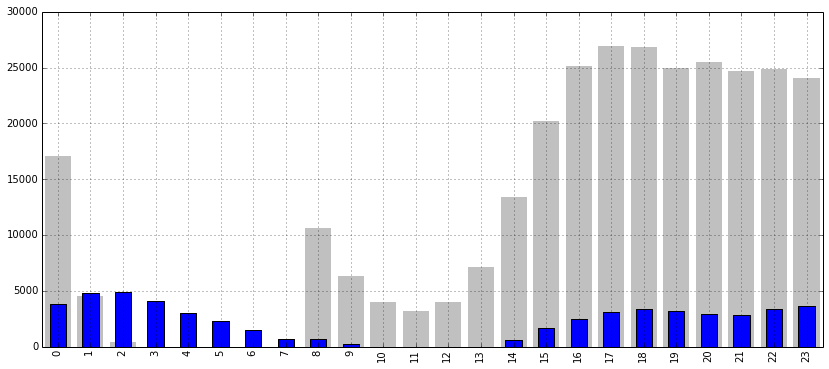

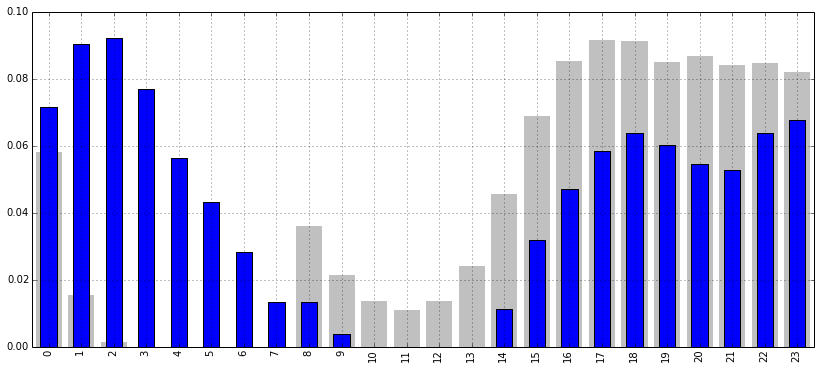

In [16]:
def chart_baselined_aggregated_hourly_interactions(ts_audience, ts_baseline, normalized=True):

    # Check result is not redacted
    if not ts_audience['analysis']['redacted'] and not ts_baseline['analysis']['redacted']:

        # Extract result data to dataframe
        df_audience = pd.DataFrame.from_records(ts_audience['analysis']['results'],index='key',exclude=['unique_authors'])
        df_audience.index=df_audience.index.map(datetime.datetime.fromtimestamp)
        df_baseline = pd.DataFrame.from_records(ts_baseline['analysis']['results'],index='key',exclude=['unique_authors'])
        df_baseline.index=df_baseline.index.map(datetime.datetime.fromtimestamp)

        # Aggregate results by hour
        df_audience = pd.DataFrame(df_audience.groupby(df_audience.index.map(lambda t: t.hour)).interactions.sum())
        df_baseline = pd.DataFrame(df_baseline.groupby(df_baseline.index.map(lambda t: t.hour)).interactions.sum())

        # If normalization is specified normalize each dataframe before plotting
        if normalized:
            df_audience = normalize_results([df_audience], 'interactions')[0]
            df_baseline = normalize_results([df_baseline], 'interactions')[0]

        df_plot = pd.concat([df_audience, df_baseline], axis=1, keys=['audience', 'baseline'])

        # Choose which column to plot depending on whether the data has been normalized
        key = 'interactions'
        if normalized:
            key = 'normalized'

        # Sort the data and plot a chart
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
        df_plot[('baseline',key)].sort_index().plot(kind='bar',ax=axes,color='silver',width=0.8,linewidth=0)
        df_plot[('audience',key)].sort_index().plot(kind='bar',ax=axes)
        
# Absolute
chart_baselined_aggregated_hourly_interactions(audience_multi_days, baseline_multi_days, normalized=False)

# Normalized
chart_baselined_aggregated_hourly_interactions(audience_multi_days, baseline_multi_days)

# What next?

Now you've learnt some further charting skills take a look at the other examples in this repository, such as:
* [Charting PYLON Nested Query Analysis Results](Charting PYLON Nested Query Analysis Results.ipynb)